# Speeding up access to large datasets with Dask Delayed

#### Scott Wales, CLEX CMS

CLEX CMS helps to maintain a number of dataset replicas at NCI, and we keep an eye out for ways to make these datasets easier to use.

The `xarray` library has been great for accessing datasets and their metadata, but one thing I have noticed is that it can be a bit slow to read in really large datasets, like the full timeseries of CMIP or ERA-Interim.

I've an idea of why that might be, let's take a look and see if we can make use of Dask to speed up loading a variable from the local ERA-Interim replica.

The local ERA-Interim replica is on NCI under the `ub4` project. Access to this project requires [registration](http://climate-cms.unsw.wikispaces.net/ERA+INTERIM). Most of the dataset is in GRIB format, but a large number of variables are also available in NetCDF format, which is what we'll look at today.

In [1]:
! ls /g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/*.nc | head

/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790101_19790131.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790201_19790228.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790301_19790331.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790401_19790430.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790501_19790531.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790601_19790630.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790701_19790731.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790801_19790831.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_19790901_19790930.nc
/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/

There are a lot of files, opening the dataset can be slow, both when we use `open_mfdataset`, as well as just opening the individual files:

In [2]:
import xarray

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
%%time
ds_mf = xarray.open_mfdataset('/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_*.nc', chunks={'time': 1})

CPU times: user 9.46 s, sys: 2.14 s, total: 11.6 s
Wall time: 35 s


In [4]:
%%time
from glob import glob
ds_concat = [xarray.open_dataset(f) for f in sorted(glob('/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_*.nc'))]

CPU times: user 6.19 s, sys: 2.16 s, total: 8.36 s
Wall time: 27.8 s


7 seconds or so isn't too bad, but can still be a nuisance if you're trying to iterate on an analysis, or if you need to load a lot of variables at once. A lot of this time is spent checking that the coordinates of each file match - can we save on time by omitting this, since the dataset is well curated?

The horizontal and vertical axes of each file are going to be exactly the same, it's only the time axis and the variable itself that are going to vary between files. If we can work out what the time axis is without actually opening the files, then the only reason we need to open the file itself is once we need the data inside it - which can be handled using `dask`. This way we can set up the full dataset without spending 7 seconds opening each and every file.

### Setting up the time axis

So how can we get the time axis of the full dataset without opening all of the files? One way is `pandas.date_range()`, which returns a series of datetimes between a start and end point, at a user definable frequency. This means for the `6hr` dataset we can get the times like:

In [5]:
import pandas
pandas.date_range('1981-08-01', '1981-08-03', freq = '6H')

DatetimeIndex(['1981-08-01 00:00:00', '1981-08-01 06:00:00',
               '1981-08-01 12:00:00', '1981-08-01 18:00:00',
               '1981-08-02 00:00:00', '1981-08-02 06:00:00',
               '1981-08-02 12:00:00', '1981-08-02 18:00:00',
               '1981-08-03 00:00:00'],
              dtype='datetime64[ns]', freq='6H')

The ERA-Interim dataset is continuously updated, so we can't just have a static start and end date for the dataset. We can get the start and end time of the dataset easily enough by opening the first and last files. We could also extract the dates from the filenames themselves, however that is slightly more complicated.

In [6]:
fs = sorted(glob('/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_*.nc'))
d0 = xarray.open_dataset(fs[0])
dn = xarray.open_dataset(fs[-1])

time = pandas.date_range(d0.time.values[0], dn.time.values[-1], freq = '6H')
print(time)

DatetimeIndex(['1979-01-01 00:00:00', '1979-01-01 06:00:00',
               '1979-01-01 12:00:00', '1979-01-01 18:00:00',
               '1979-01-02 00:00:00', '1979-01-02 06:00:00',
               '1979-01-02 12:00:00', '1979-01-02 18:00:00',
               '1979-01-03 00:00:00', '1979-01-03 06:00:00',
               ...
               '2018-05-29 12:00:00', '2018-05-29 18:00:00',
               '2018-05-30 00:00:00', '2018-05-30 06:00:00',
               '2018-05-30 12:00:00', '2018-05-30 18:00:00',
               '2018-05-31 00:00:00', '2018-05-31 06:00:00',
               '2018-05-31 12:00:00', '2018-05-31 18:00:00'],
              dtype='datetime64[ns]', length=57584, freq='6H')


### Lazily loading files

Now we only want to load the files if we're actually going to look at them. This is the same thing that dask does for chunks within a file, but we want the lazy loading to work on the whole file, so that `xarray.open_dataset()` itself only gets run when we need that file's data.

To do this, we need to create a function using the decorator `dask.delayed`. This tells Dask that we want to run the function lazily, so it only runs when we need the output. The delayed result then needs to be changed into an array, using the function `dask.array.from_delayed()`. In addition to the delayed result, we also need to say what the size of the array will be, and what type its values are. Since the delayed function hasn't been run yet Dask has no way of telling this itself.

In [7]:
import dask

# This function only gets run when dask needs to look at the result
@dask.delayed
def open_datefile_delayed(t0):
    # I've added a print() here to show when the delayed function gets run
    print('open_datefile_delayed(%s)'%t0)
    
    # Otherwise it just opens and returns the file as a xarray.Dataset
    return xarray.open_dataset(glob('/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/clt/clt_6hrs_ERAI_historical_an-pl_%04d%02d*.nc'%(t0.year, t0.month))[0],
                               chunks={'time':1})

def open_datefile(t0):
    # Prepare to open the file
    var_data = open_datefile_delayed(t0)['clt'].data
    
    # Get the size of the time axis - the number of 6 hour intervals between the beginning and end of the month
    time = pandas.date_range(start = t0 - pandas.tseries.offsets.MonthBegin(),
                             end = t0 + pandas.tseries.offsets.MonthBegin(),
                             freq='6H',
                             closed='left')
    
    # Tell Dask the delayed function returns an array, and the size and type of that array
    return dask.array.from_delayed(var_data, (time.size, d0.lev.size, d0.lat.size, d0.lon.size), d0['clt'].dtype)

We can then run this function on each month between the start and end date, and concatenate the results into a single Dask array

In [8]:
months = pandas.date_range(d0.time.values[0], dn.time.values[-1], freq = '1M')

# Run open_datefile on each month of the dataset - note that open_datefile_delayed() hasn't yet been run
delayed_clt = dask.array.concatenate([open_datefile(t) for t in months], axis=0)
delayed_clt

dask.array<concatenate, shape=(57584, 37, 241, 480), dtype=float32, chunksize=(124, 37, 241, 480)>

And then convert that dask array to an Xarray dataset by adding in all the coordinates - `time` is calculated using Pandas, the rest come from the first file

In [9]:
clt = xarray.DataArray(delayed_clt,
                 dims = ['time','lev','lat','lon'],
                 coords = {
                     'time': pandas.date_range(d0.time.values[0], dn.time.values[-1], freq='6H'),
                     'lat': d0.lat,
                     'lon': d0.lon,
                     'lev': d0.lev,
                 },
                name = d0.clt.name,
                attrs = d0.clt.attrs)
clt

<xarray.DataArray 'clt' (time: 57584, lev: 37, lat: 241, lon: 480)>
dask.array<shape=(57584, 37, 241, 480), dtype=float32, chunksize=(124, 37, 241, 480)>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T06:00:00 ...
  * lat      (lat) float64 90.0 89.25 88.5 87.75 87.0 86.25 85.5 84.75 84.0 ...
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 -177.0 -176.2 -175.5 ...
  * lev      (lev) float64 1e+05 9.75e+04 9.5e+04 9.25e+04 9e+04 8.75e+04 ...
Attributes:
    standard_name:  cloud_area_fraction
    long_name:      Cloud cover 
    units:          1
    code:           248
    table:          128
    MD5:            0845c2411253ce851831553506e289d9

Finally we should make sure that the data from the delayed function is the same as opening the dataset using `open_mfdataset`

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

open_datefile_delayed(1979-01-31 00:00:00)
open_datefile_delayed(1980-01-31 00:00:00)
open_datefile_delayed(1981-01-31 00:00:00)
open_datefile_delayed(1982-01-31 00:00:00)
open_datefile_delayed(1983-01-31 00:00:00)
open_datefile_delayed(1984-01-31 00:00:00)
open_datefile_delayed(1985-01-31 00:00:00)
open_datefile_delayed(1986-01-31 00:00:00)
open_datefile_delayed(1987-01-31 00:00:00)
open_datefile_delayed(1988-01-31 00:00:00)
open_datefile_delayed(1989-01-31 00:00:00)
open_datefile_delayed(1990-01-31 00:00:00)
open_datefile_delayed(1991-01-31 00:00:00)
open_datefile_delayed(1992-01-31 00:00:00)open_datefile_delayed(1993-01-31 00:00:00)

open_datefile_delayed(1994-01-31 00:00:00)
open_datefile_delayed(1995-01-31 00:00:00)
open_datefile_delayed(1996-01-31 00:00:00)
open_datefile_delayed(1997-01-31 00:00:00)
open_datefile_delayed(1998-01-31 00:00:00)
open_datefile_delayed(1999-01-31 00:00:00)
open_datefile_delayed(2000-01-31 00:00:00)
open_datefile_delayed(2001-01-31 00:00:00)
open_datefi

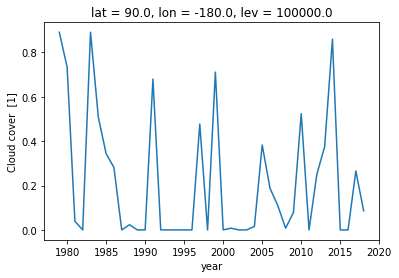

In [11]:
%%time

clt.isel(lev=0, lat=0, lon=0).groupby('time.year').first(skipna=False).plot()

CPU times: user 7.19 s, sys: 328 ms, total: 7.52 s
Wall time: 7.41 s


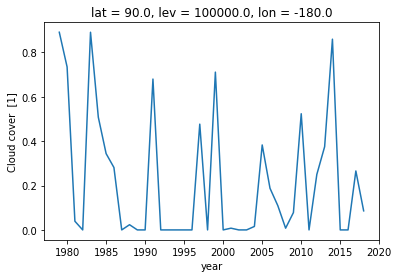

In [12]:
%%time

ds_mf.clt.isel(lev=0, lat=0, lon=0).groupby('time.year').first(skipna=False).plot()

Putting everything into a function:

In [13]:
@dask.delayed
def open_datefile_delayed(time, variable):
    return xarray.open_dataset(glob('/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/%(var)s/%(var)s_6hrs_ERAI_historical_an-pl_%(Y)04d%(M)02d*.nc'%
                                    {'var': variable, 'Y': time.year, 'M': time.month})[0],
                               chunks={'time':1})

def open_datefile(time, variable, var0):
    # Prepare to open the file
    var_data = open_datefile_delayed(time, variable)[variable].data
    
    # Get the size of the time axis - the number of 6 hour intervals between the beginning and end of the month
    time_axis = pandas.date_range(start = time - pandas.tseries.offsets.MonthBegin(),
                             end = time + pandas.tseries.offsets.MonthBegin(),
                             freq='6H',
                             closed='left')
    
    # Tell Dask the delayed function returns an array, and the size and type of that array
    return dask.array.from_delayed(var_data, (time_axis.size, var0.lev.size, var0.lat.size, var0.lon.size), var0.dtype)

def open_erai(variable):
    files = sorted(glob('/g/data1/ub4/erai/netcdf/6hr/atmos/oper_an_pl/v01/%(var)s/%(var)s_6hrs_ERAI_historical_an-pl_*.nc'%
                 {'var': variable}))
    ds0 = xarray.open_dataset(files[0])
    dsn = xarray.open_dataset(files[-1])
    
    time = pandas.date_range(ds0.time.values[0], dsn.time.values[-1], freq='6H')
    var0 = ds0[variable]
    
    months = pandas.date_range(ds0.time.values[0], dsn.time.values[-1], freq='1M')
    dask_var = dask.array.concatenate([open_datefile(t, variable, var0) for t in months], axis=0)
    
    var = xarray.DataArray(dask_var,
                          name = var0.name,
                          attrs = var0.attrs,
                          dims = ['time', 'lev', 'lat', 'lon'],
                          coords = {
                              'time': time,
                              'lev': var0.lev,
                              'lat': var0.lat,
                              'lon': var0.lon,
                          })
    
    ds0.close()
    dsn.close()
    
    return var

CPU times: user 1.21 s, sys: 83 ms, total: 1.29 s
Wall time: 1.3 s


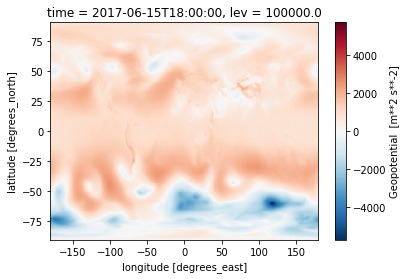

In [14]:
%%time

z = open_erai('z')
z.sel(time='20170615T1800').isel(lev=0).plot()